In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Funciones y librerías

## librerías, rutas y datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from keras.models import model_from_json
import IPython

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.activations import relu, sigmoid
from sklearn.model_selection import train_test_split

ruta_data = '/content/drive/MyDrive/Entregable/datos/'
ruta_modelo = '/content/drive/MyDrive/Entregable/modelos/'
variables = ['kwh_rec', 'kvarh_rec', 'kwhr_del', 'kvarh_del']

umbrales = json.load(open(ruta_data + 'umbrales.json', 'r'))
p = 0.4
print("Estos umbrales deben coincidir con los usados en la función TRITURADOR!!\n",umbrales)

Estos umbrales deben coincidir con los usados en la función TRITURADOR!!
 {'kwh_rec': 1028.6608628646331, 'kvarh_rec': 188.50717752481475, 'kwhr_del': 221.77786732377683, 'kvarh_del': 83.791620560437}


## funciones simples

In [ ]:
# Función para imprimir temporalmente, y visualizar progresos
def print_temp(string = None, out = None):
  """
  Imprime, actualiza y borra mensajes temporales.

  Ejemplo:
    >>> out = print_temp('primer mensaje mostrado')
    primer mensaje mostrado
    >>> print_temp('segundo mensaje mostrado',out)
    segundo mensaje mostrado <encima del mensaje anterior>
    >>> print_temp()
    <vacío>
  """
  if out == None and not string == None:
    return(display(IPython.display.Pretty(string), display_id = True))
  if string == None:
    IPython.display.clear_output()
  else:
    out.update(IPython.display.Pretty(string))

out = print_temp('primer mensaje') # Empieza a imprimir con este código
print_temp('nuevo mensaje',out)    # Luego, se actualiza el mensaje con esto
print_temp()                       # Finalmente, se borra el mensaje

## funciones avanzadas

In [ ]:
def cargar_semana(path,year=None,month=None,day=None):
  """
  Carga los dataframes necesarios para cargar el día mencionado y los 7 días anteriores.
  En path deben estar archivos csv con nombres de forma "datos_añomes.csv"

  Ejemplo:
    path: '/content/drive/MyDrive/Entregable/datos/' (ó 'datos\' en caso de trabajar en jupyter notebook, donde datos es el nombre de la carpeta)
    archivo: 'datos_202201.csv'

  Luego de cargar los datos necesarios (Si el día corresponde entre 1 y 8 del mes, también cargará el mes anterior), hará un preprocesamiento que consiste en:
  1. Juntar variables temporales en una única variable formato fecha.
  2. Eliminar filas con datos NaN.
  3. Ordenar por id_empresa -> id_med -> dt.
  4. Eliminar mediciones duplicadas.
  5. Seleccionar variables importantes.
  6. Seleccionar solo la semana deseada.
  """
  if (year is None) + (month is None) + (day is None) > 0:
    raise Exception("Ocurrió un error: Ingrese año, mes y día a evaluar")
  if day < 9:
    if month == 1:
      df_1 = pd.read_csv(path + "datos_"+str(year-1)+"12.csv",sep=";")
      df_2 = pd.read_csv(path + "datos_"+str(year)  +"01.csv",sep=";")
    elif month < 10:
      df_1 = pd.read_csv(path + "datos_"+str(year)+"0"+str(month-1)+".csv",sep=";")
      df_2 = pd.read_csv(path + "datos_"+str(year)+"0"+str(month)+".csv",sep=";")
    elif month == 10:
      df_1 = pd.read_csv(path + "datos_"+str(year)+"09.csv",sep=";")
      df_2 = pd.read_csv(path + "datos_"+str(year)+"10.csv",sep=";")
    else:
      df_1 = pd.read_csv(path + "datos_"+str(year)+str(month-1)+".csv",sep=";")
      df_2 = pd.read_csv(path + "datos_"+str(year)+str(month)+".csv",sep=";")


    df_1["dt"] = df_1["fecha"]+df_1["hora"]
    df_1["dt"] = pd.to_datetime(df_1["dt"], format="%Y-%m-%d%H:%M:%S")
    df_1 = df_1[["dt","kwh_rec","kvarh_rec","kwhr_del","kvarh_del","activos_puros","reactivos","id_empresa","id_barra","id_med","id_tipo_contrato"]].copy()
    df_1 = df_1.dropna(axis=0)
    df_1 = df_1.sort_values(by=["id_empresa","id_med","dt"]).reset_index(drop=True)
    df_1 = df_1.drop_duplicates(subset=['dt', 'id_med'],keep="first").reset_index(drop=True)
    df_1 = df_1[["dt","kwh_rec","kvarh_rec","kwhr_del","kvarh_del","id_med","id_tipo_contrato"]].copy()

    df_2["dt"] = df_2["fecha"]+df_2["hora"]
    df_2["dt"] = pd.to_datetime(df_2["dt"], format="%Y-%m-%d%H:%M:%S")
    df_2 = df_2[["dt","kwh_rec","kvarh_rec","kwhr_del","kvarh_del","activos_puros","reactivos","id_empresa","id_barra","id_med","id_tipo_contrato"]].copy()
    df_2 = df_2.dropna(axis=0)
    df_2 = df_2.sort_values(by=["id_empresa","id_med","dt"]).reset_index(drop=True)
    df_2 = df_2.drop_duplicates(subset=['dt', 'id_med'],keep="first").reset_index(drop=True)
    df_2 = df_2[["dt","kwh_rec","kvarh_rec","kwhr_del","kvarh_del","id_med","id_tipo_contrato"]].copy()

    df = pd.concat([df_1,df_2],axis=0)

  else:
    if month < 10:
      df = pd.read_csv(path + "datos_"+str(year)+"0"+str(month)+".csv",sep=";")
    else:
      df = pd.read_csv(path + "datos_"+str(year)+str(month)+".csv",sep=";")

    df["dt"] = df["fecha"]+df["hora"]
    df["dt"] = pd.to_datetime(df["dt"], format="%Y-%m-%d%H:%M:%S")
    df = df[["dt","kwh_rec","kvarh_rec","kwhr_del","kvarh_del","activos_puros","reactivos","id_empresa","id_barra","id_med","id_tipo_contrato"]].copy()
    df = df.dropna(axis=0)
    df = df.sort_values(by=["id_empresa","id_med","dt"]).reset_index(drop=True)
    df = df.drop_duplicates(subset=['dt', 'id_med'],keep="first").reset_index(drop=True)
    df = df[["dt","kwh_rec","kvarh_rec","kwhr_del","kvarh_del","id_med","id_tipo_contrato"]].copy()


  medidores = sorted(list(df["id_med"].unique()))

  dt_end = pd.to_datetime(str(year)+'-'+str(month)+'-'+str(day))
  dt_start = dt_end - pd.DateOffset(days=7)

  df = df.loc[(df["dt"] >= dt_start) & (df["dt"] <= dt_end + pd.DateOffset(hours=23, minutes=45))].reset_index(drop=True)

  return(df)

def import_months(path,dates):
  """
  Carga los dataframes correspondiente a las fechas presentadas en la lista de tuplas: dates.

  Ejemplo:
    path: '/content/drive/MyDrive/Entregable/datos/' (ó 'datos\' en caso de trabajar en jupyter notebook, donde datos es el nombre de la carpeta)
    dates: [(1,2020),(2,2020), ... , (12,2020), ...]

  Luego de cargar los datos necesarios (Si el día corresponde entre 1 y 8 del mes, también cargará el mes anterior), hará un preprocesamiento que consiste en:
  1. Juntar variables temporales en una única variable formato fecha.
  2. Eliminar filas con datos NaN.
  3. Ordenar por id_empresa -> id_med -> dt.
  4. Eliminar mediciones duplicadas.
  5. Seleccionar variables importantes.
  """
  out = print_temp('Importando archivos...')
  for i, (month, year) in enumerate(dates):
    if month < 10:
      month = f'0{month}'
    print_temp(f'Importando archivos {i+1}/{len(dates)} ({month}-{year})...',out)
    df = pd.read_csv(path + f"datos_{year}{month}.csv",sep=";")
    df["dt"] = df["fecha"]+df["hora"]
    df["dt"] = pd.to_datetime(df["dt"], format="%Y-%m-%d%H:%M:%S")
    df = df[["dt","kwh_rec","kvarh_rec","kwhr_del","kvarh_del","activos_puros","reactivos","id_empresa","id_barra","id_med","id_tipo_contrato"]].copy()
    df = df.dropna(axis=0)
    df = df.sort_values(by=["id_empresa","id_med","dt"]).reset_index(drop=True)
    df = df.drop_duplicates(subset=['dt', 'id_med'],keep="first").reset_index(drop=True)
    df = df[["dt","kwh_rec","kvarh_rec","kwhr_del","kvarh_del","id_med","id_tipo_contrato"]].copy()

    if i == 0:
      DF = df
    else:
      DF = pd.concat((DF,df),axis=0,ignore_index=True)
    DF = DF.sort_values(by=["id_med","dt"]).reset_index(drop=True)
  return(DF)

In [ ]:
def triturador(df):
  """
  Función para ser aplicada en groupby('id_med')[['dt',variable]], obteniendo en df un DataFrame con columnas ['dt','<variable>'] el cual será despedazado en varias sub-series.
  Aquí, se tiene la serie completa asociada a uno de los medidores y a la variable '<variable>', se rescata las fechas (dt) asociadas a la serie temporal y la serie (ts) de la variable '<variable>'.
  El umbral se supone que debe ser el mismo al cargado al inicio en el apartado de librerías (Se dejó internamente para optimizar el código).

  Se debe actualizar el código para modifcar el largo deseado de la serie (8 días = 4*24*8) y cada cuanto separará las subseries (Cada 1 día = 4*24)

  Las sub-series serán añadidas en 'data' junto a su fecha de inicio y fin en 'times'. Si la sub-serie no supera el umbral, no será añadida.
  Luego de obtener 'data' y 'times', retorna un DataFrame especial con el nombre de la variable que se tomó, el inicio y fin de cada sub-serie (En cada casilla) y la data de cada sub-serie (en cada casilla)

  Ejemplo:
    >>> DF = df.groupby('id_med')[['dt','kwh_rec']].reset_index().drop(columns=['idx']) # al hacer reset_index, se vuelven columnas los indices asociados al medidor y al N° de sub-serie de la serie original
    >>> DF
        id_med    variable                                   inic-fin                  data
    0        7     kwh_rec      [1-1-2020 00:00:00,8-1-2020 23:45:00]       [0,1,2,...,767]
    1        7     kwh_rec      [2-1-2020 00:00:00,9-1-2020 23:45:00]    [96,97,98,...,863]
    2        7     kwh_rec     [4-1-2020 00:00:00,11-1-2020 23:45:00]   [192,97,98,...,951]
    ...
    9       41     kwh_rec     [31-1-2020 00:00:00,7-2-2020 23:45:00]    [96,97,98,...,863]

  """
  df.reset_index(drop=True,inplace=True)
  #id_med = df.loc[0,'id_med']
  variable = df.columns[-1]
  umbr = {'kwh_rec': 1028.6608628646331, 'kvarh_rec': 188.50717752481475, 'kwhr_del': 221.77786732377683, 'kvarh_del': 83.791620560437}[variable]
  dt = df['dt'].to_numpy().reshape(-1)
  ts = df.iloc[:,-1].to_numpy().reshape(-1)

  largo_deseado = 4*24*8 # 4 mediciones por hora, 24 horas al día, 8 días
  cada_cuanto = 4*24     # cada día
  l = len(ts)

  data = np.zeros((l,largo_deseado))
  times = np.empty((l,2),'datetime64[ns]')
  i = 0
  for j in np.arange(0,l-largo_deseado+1,cada_cuanto):
    ts_ = ts[j:(j+largo_deseado)]
    if np.mean(ts_) > umbr:
      times[i] = dt[[j,j+largo_deseado-1]]
      data[i] = ts_
      i += 1
  if i > 0:
    data = data[:i]
    times = times[:i]
    df_ = pd.DataFrame(index=np.arange(0,i))
    df_.index.name = 'idx'
    #df_.loc[:,'id_med'] = id_med
    df_.loc[:,'variable'] = variable
    df_.loc[:,'inic-fin'] = [t for t in times]
    df_.loc[:,'data'] = [d for d in data]
    return(df_)

In [ ]:
# Estas funciones sirven para ver que las series sean efectivamente cada 15 minutos
def find_jumps(dt):
  # Recibe las fechas
  dt = np.array(dt).reshape(-1)
  # Define el orden correcto que debería tener (Cada 15 minutos)
  dt_min = np.min(dt)
  dt_max = np.max(dt)
  dt_ideal = pd.date_range(start=dt_min, end=dt_max, freq='15T')
  # Corrobora que dt no sea más largo de lo esperado
  l = len(dt)
  if l > len(dt_ideal):
    global dt_error
    dt_error = dt
    raise ValueError('Hay muchas fechas en este periodo, vea la variable "dt_error"')
  # Al ser de igual largo o menor, define los primeros l de dt_ideal que deberían ir coincidiendo con dt, si no coincide completamente (Puesto que hay menos fechas), encuentra dónde no coincide
  # y corta dt, para seguir encontrando dónde (where) se hacen estos cortes
  where = [0,l]
  eqs = dt == dt_ideal[:l]
  while not np.all(eqs):
    i = np.where(eqs == False)[0][0]
    dt = dt[i:]
    dt_min = np.min(dt)
    dt_max = np.max(dt)
    dt_ideal = pd.date_range(start=dt_min, end=dt_max, freq='15T')
    l = len(dt)
    eqs = dt == dt_ideal[:l]
    where += [i]
  where = list(sorted(where))
  return(where)

def df_to_numpy(dataf):
  return(dataf.to_numpy())

def split_data(row):
  # Corta los datos según lo obtenido por find_jumps
  splited_data = []
  id_med = row['data'][0,5]
  l = len(row['jumps']) - 1

  for i in range(l):
    new_data = row['data'][row['jumps'][i]:row['jumps'][i+1]]
    new_data[:,5] = id_med + np.round(i/l,4)
    splited_data += [new_data]
  return(splited_data)

In [ ]:
## Spectral Residual

def average_filter(values,q=3):
  # average filter along the second axis, values is an (m x n)-array of m entries by n timestamps
  if q >= values.shape[1]:
    q = values.shape[1]

  average = np.cumsum(values, axis=1, dtype=float)
  average[:,q:] = average[:,q:] - average[:,:-q]
  average[:,q:] = average[:,q:] / q

  for i in range(1, q):
    average[:,i] /= (i + 1)

  return average

def predict_next(values):
  """
  Predicts the next value by sum up the slope of the last value with previous values.
  Mathematically, g = 1/m * sum_{i=1}^{m} g(x_n, x_{n-i}), x_{n+1} = x_{n-m+1} + g * m,
  where g(x_i,x_j) = (x_i - x_j) / (i - j)
  :param values: list.
      a list of float numbers.
  :return : float.
      the predicted next value.
  """

  m,n = values.shape

  if n <= 1:
    raise ValueError(f'data should contain at least 2 numbers')

  v_last = values[:,-1]

  slopes = np.zeros((m,n-1))
  for i in range(n-1):
    slopes[:,i] = (v_last - values[:,i]) / (n - 1 - i)
  #slopes = [(v_last - v) / (n - 1 - i) for i, v in enumerate(values[:-1])]

  return((values[:,1] + np.sum(slopes,axis=1)).reshape(-1,1))

def extend_series(values, extend_num=5, look_ahead=5):
  """
  extend the array data by the predicted next value
  :param values: list.
    a list of float numbers.
  :param extend_num: int, default 5.
    number of values added to the back of data.
  :param look_ahead: int, default 5.
    number of previous values used in prediction.
  :return: list.
    The result array.
  """

  if look_ahead < 1:
    raise ValueError('look_ahead must be at least 1')

  extension = predict_next(values[:,-look_ahead - 2:-1])
  for i in range(extend_num):
    values = np.concatenate((values, extension), axis=1)
  return(values)

def SR(ts,q=3,verbose=False):
  # ts is m entries with n timestamps and returns the spectral residual of the m entries
  EPS = 1e-8
  m,n = ts.shape
  hq = np.ones((q, q), dtype=int)/(q**2)

  if verbose:
    out = print_temp('Calculando transformada...')
  fourier_transform = np.fft.fft(ts,axis=1)
  A = np.abs(fourier_transform)  # Amplitud
  XX,YY = np.where(A <= EPS)
  A[(XX,YY)] = EPS
  P = np.angle(fourier_transform)    # Fase en radianes

  if verbose:
    print_temp('Modificando transformada...', out)
  L = np.log(A)
  L[(XX,YY)] = 0
  AL = average_filter(L,q)
  R = np.subtract(L,AL)
  trans = np.exp(np.add(R, 1j * P))
  trans.real[(XX,YY)] = 0
  trans.imag[(XX,YY)] = 0

  if verbose:
    print_temp('Calculando transformada inversa...', out)
  S = np.abs(np.fft.ifft(trans,axis=1))
  if verbose:
    print_temp()
  return(S)

def SR_activation(S,tau=0.1,z=4):
  if z >= S.shape[1]:
    z = S.shape[1]

  average = np.cumsum(S, axis=1, dtype=float)
  average[:,z:] = average[:,z:] - average[:,:-z]
  average[:,z:] = average[:,z:] / z

  for i in range(1, z):
    average[:,i] /= (i + 1)

  average = np.concatenate((average[:,0].reshape(-1,1),average[:,:-1]),axis=1)
  delta = S-average
  activacion = np.where(delta > (tau+np.percentile(delta,95,axis=1)).reshape(-1,1),1,0)
  return(activacion)

In [ ]:
def calcular_input_output(X,q=3,z=4,tau=0.1):
  CNN_input = SR(extend_series(X),q)
  CNN_output = SR_activation(CNN_input,tau,z)

  CNN_input = CNN_input[:,(X.shape[1]-96*7):X.shape[1]]
  CNN_output = CNN_output[:,(X.shape[1]-96*7):X.shape[1]]
  return(CNN_input,CNN_output)

In [ ]:
# CNN
#from keras.callbacks import ModelCheckpoint
#filepath = "model_checkpoint.h5"
def modelo_CNN(input,output,epochs=40,batch_size=2**10,verbose=1):
  # Crea un modelo usando de entrada input = Spectral Residual, output = f. activación SR
  # retornando el modelo y su historial
  X = input.reshape((input.shape[0],input.shape[1],1))
  y = output
  n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]

  #verbose, epochs, batch_size = 1, 60, 2**12
  n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(filters=2 * 64, kernel_size=1, activation='relu'))
  model.add(Flatten())
  model.add(Dense(4 * 64, activation='relu'))
  model.add(Dense(n_outputs, activation='sigmoid'))

  # Compila el modelo
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Entrena el modelo
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=verbose)#, callbacks=[learning_rate_scheduler] = [checkpoint]
  return(model,history)

def guardar_modelo(ruta,modelo,nombre = 'modelo',version=None):
  # Guarda el modelo en la ruta deseada, puede cambiar el nombre del modelo y la versión.
  out = print_temp('Exportando modelo...')
  if version == None:
    nombre_archivo = ruta + nombre
  else:
    nombre_archivo = ruta + nombre + f' ({version})'

  modelo_json = modelo.to_json()
  with open(nombre_archivo+".json", "w") as json_file:
      json_file.write(modelo_json)
  # serializar los pesos a HDF5
  modelo.save_weights(nombre_archivo+".h5")

  if version == None:
    print_temp(f"{nombre} ha sido cargado en el disco.",out)
  else:
    print_temp(f"{nombre} {version} ha sido cargado en el disco.",out)

def cargar_modelo(ruta,nombre = 'modelo',version = None):
  # Carga el modelo desde la ruta deseada
  out = print_temp('Importando modelo...')
  if version == None:
    nombre_archivo = ruta + nombre
  else:
    nombre_archivo = ruta + nombre + f' ({version})'

  # cargar json y crear el modelo
  json_file = open(nombre_archivo+ '.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  modelo = model_from_json(loaded_model_json)

  # cargar pesos al nuevo modelo y compilar
  modelo.load_weights(nombre_archivo+ '.h5')
  modelo.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

  if version == None:
    print_temp(f"{nombre} ha sido importado desde el disco.",out)
  else:
    print_temp(f"{nombre} {version} ha sido importado desde el disco.",out)
  return(modelo)

In [ ]:
def ajustar_anomalias(ts,anom,verbose=False):
  A = np.max(ts) - np.min(ts)
  n = len(ts)
  anom_ = dict()
  eliminaciones = 0
  for i in anom:
    if (i < 2) | (i > n-1-2):
      if not i in anom_.keys():
        anom_[i] = 's/n'
      continue
    lat = np.arange(i-2,i+2)
    ts_lat = np.mean(ts[lat])
    izq = np.arange(i-8,i-2)
    der = np.arange(i+2,i+8)
    if i < 8:
      ts_der = np.mean(ts[der])
      if (ts_lat - ts_der > 0.05*A) & (not i in anom_.keys()):
        for j in np.arange(0,i+1):
          anom_[j] = 'subidón'
      elif (ts_lat - ts_der < 0.05*A) & (not i in anom_.keys()):
        for j in np.arange(0,i+1):
          anom_[j] = 'caída'
      continue
    if i > n-1-8:
      ts_izq = np.mean(ts[izq])
      if i in anom_.keys():
        continue
      if (ts_lat - ts_izq > 0.05*A):
        for j in np.arange(i,n):
          anom_[j] = 'subidón'
      elif (ts_izq - ts_lat > 0.05*A):
        for j in np.arange(i,n):
          anom_[j] = 'caída'
      else:
        anom_[i] = 's/n'
      continue
    ts_izq = np.mean(ts[izq])
    ts_der = np.mean(ts[der])
    ext = np.array(sorted(set(izq) | set(der)))

    # Falsa anomalía
    if (np.max(np.abs(ts[lat]-ts[lat].reshape(-1,1)),axis=None) < 0.01*A) & (np.max(np.abs(ts[lat]-ts[ext].reshape(-1,1)),axis=None) < 0.2*A):
      if not i in anom_.keys():
        eliminaciones += 1
      continue

    # ¿Cambia o solo sobresale?
    if (np.abs(ts_izq - ts_der) < 0.15*A) | ((np.abs(ts[i]-ts_izq) > 0.3*A) & (np.abs(ts[i]-ts_der) > 0.3*A)):  ## SOBRESALE ##
      # ¿Quiénes sobresalen?
      sal = False
      if ts_izq < ts_lat:
        salencia = 'subidón'
      else:
        salencia = 'caída'
      for j in lat:
        if (np.abs(ts[j]-ts_izq) > 0.05*A) & (np.abs(ts[j]-ts_der) > 0.05*A):
          if not j in anom_.keys():
            anom_[j] = salencia
            sal = True
          elif anom_[j] == 's/n':
            anom_[j] = salencia
            sal = True
      if sal:
        continue
    else: ####################################################################################################  ## CAMBIA ##
      # ¿Hacia dónde cambia?
      if np.abs(ts[i-1]-ts[i]) > np.abs(ts[i]-ts[i+1]):
        j = i-1
      else:
        j = i+1
      if not i in anom_.keys():
        anom_[i] = 'pto. cambio'
      elif anom_[i] in ['subidón','caída', 's/n']:
        anom_[i] = 'pto. cambio'
      if not j in anom_.keys():
        anom_[j] = 'pto. cambio'
      elif anom_[j] in ['subidón','caída', 's/n']:
        anom_[j] = 'pto. cambio'
      continue

    # sin info ####################################
    if not i in anom_.keys():
      anom_[i] = 's/n'


  if verbose & (eliminaciones > 0):
    print('Total eliminaciones:',eliminaciones)
  return(np.array(list(anom_.keys()),int), np.array(list(anom_.values()),str))

def ajustar_anomalias_con_eliminaciones(ts,anom,verbose=False):
  A = np.max(ts) - np.min(ts)
  n = len(ts)
  anom_ = dict()
  eliminaciones = 0
  for i in anom:
    if (i < 2) | (i > n-1-2):
      if not i in anom_.keys():
        anom_[i] = 's/n'
      continue
    lat = np.arange(i-2,i+2)
    ts_lat = np.mean(ts[lat])
    izq = np.arange(i-8,i-2)
    der = np.arange(i+2,i+8)
    if i < 8:
      ts_der = np.mean(ts[der])
      if (ts_lat - ts_der > 0.05*A) & (not i in anom_.keys()):
        for j in np.arange(0,i+1):
          anom_[j] = 'subidón'
      elif (ts_lat - ts_der < 0.05*A) & (not i in anom_.keys()):
        for j in np.arange(0,i+1):
          anom_[j] = 'caída'
      continue
    if i > n-1-8:
      ts_izq = np.mean(ts[izq])
      if i in anom_.keys():
        continue
      if (ts_lat - ts_izq > 0.05*A):
        for j in np.arange(i,n):
          anom_[j] = 'subidón'
      elif (ts_izq - ts_lat > 0.05*A):
        for j in np.arange(i,n):
          anom_[j] = 'caída'
      else:
        anom_[i] = 's/n'
      continue
    ts_izq = np.mean(ts[izq])
    ts_der = np.mean(ts[der])
    ext = np.array(sorted(set(izq) | set(der)))

    # Falsa anomalía
    if (np.max(np.abs(ts[lat]-ts[lat].reshape(-1,1)),axis=None) < 0.01*A) & (np.max(np.abs(ts[lat]-ts[ext].reshape(-1,1)),axis=None) < 0.2*A):
      if not i in anom_.keys():
        eliminaciones += 1
        anom_[i] = 'falsa anom.'
      continue

    # ¿Cambia o solo sobresale?
    if (np.abs(ts_izq - ts_der) < 0.15*A) | ((np.abs(ts[i]-ts_izq) > 0.3*A) & (np.abs(ts[i]-ts_der) > 0.3*A)):  ## SOBRESALE ##
      # ¿Quiénes sobresalen?
      sal = False
      if ts_izq < ts_lat:
        salencia = 'subidón'
      else:
        salencia = 'caída'
      for j in lat:
        if (np.abs(ts[j]-ts_izq) > 0.05*A) & (np.abs(ts[j]-ts_der) > 0.05*A):
          if not j in anom_.keys():
            anom_[j] = salencia
            sal = True
          elif anom_[j] == 's/n':
            anom_[j] = salencia
            sal = True
      if sal:
        continue
    else: ####################################################################################################  ## CAMBIA ##
      # ¿Hacia dónde cambia?
      if np.abs(ts[i-1]-ts[i]) > np.abs(ts[i]-ts[i+1]):
        j = i-1
      else:
        j = i+1
      if not i in anom_.keys():
        anom_[i] = 'pto. cambio'
      elif anom_[i] in ['subidón','caída', 's/n']:
        anom_[i] = 'pto. cambio'
      if not j in anom_.keys():
        anom_[j] = 'pto. cambio'
      elif anom_[j] in ['subidón','caída', 's/n']:
        anom_[j] = 'pto. cambio'
      continue

    # sin info ####################################
    if not i in anom_.keys():
      anom_[i] = 's/n'


  if verbose & (eliminaciones > 0):
    print('Total eliminaciones:',eliminaciones)
  return(np.array(list(anom_.keys()),int), np.array(list(anom_.values()),str))



# Modelación

## Crear data de entrenamiento

In [ ]:
# Si se quieren importar varios meses
meses = [(i,2022) for i in np.arange(5,12)]
df = import_months('/content/drive/MyDrive/Yerko/',meses)
# Si solo se quiere importar una semana (o última fecha)
#año, mes, día = (2022, 7, 22)
#df = cargar_semana(ruta_data,año,mes,día)
df

In [ ]:
#df.to_csv(ruta_data + 'df_train.csv',index=False)
#df = pd.read_csv(ruta_data + 'df_train.csv')

In [ ]:
### subdividir saltos
columns = df.columns

jumps = df.groupby('id_med')['dt'].apply(find_jumps).rename('jumps')
data_by_med = df.groupby('id_med').apply(df_to_numpy).rename('data')
data_by_med = pd.concat((jumps,data_by_med),axis=1)

df = data_by_med.apply(split_data,axis=1)
df = np.vstack(df.apply(lambda x : np.vstack(x)))
df = pd.DataFrame(df,columns = columns)

print('Si lo siguiente, tiene otros valores apartes de [0.0], es porque ocurren saltos temporales:\n',np.unique(np.mod(df['id_med'],1)))
df.head()

Si lo siguiente, tiene otros valores apartes de [0.0], es porque ocurren saltos temporales:
 [0.0 0.333299999999781 0.33329999999999416 0.33330000000000126
 0.33330000000000837 0.5 0.6666999999999916 0.6666999999999987
 0.6667000000000058 0.666700000000219]


,dt,kwh_rec,kvarh_rec,kwhr_del,kvarh_del,id_med,id_tipo_contrato
0,2022-05-01 00:00:00,175.608368,0.0,0.0,185.136383,7.0,3
1,2022-05-01 00:15:00,167.22702,0.0,0.0,185.561295,7.0,3
2,2022-05-01 00:30:00,162.141098,0.0,0.0,185.227158,7.0,3
3,2022-05-01 00:45:00,156.167694,0.0,0.0,187.221207,7.0,3
4,2022-05-01 01:00:00,154.460709,0.0,0.0,189.372208,7.0,3


In [ ]:
#df.to_csv(ruta_data + 'df_train.csv',index=False)
df = pd.read_csv(ruta_data + 'df_train.csv')

In [ ]:
out = print_temp('Creando subseries...')
DF = pd.DataFrame(columns=['id_med','variable','inic-fin','data'])
for variable in variables:
  print_temp(f'Creando subseries para {variable}',out)
  result = df.groupby('id_med')[['dt',variable]].apply(triturador).reset_index()
  if result.shape[0] > 0:
    DF = pd.concat((DF,result),axis=0,ignore_index=True)
  else:
    print(f'No se presentan series significantes en la variable {variable}')
print_temp('',out)
DF.drop(columns=['idx'],inplace=True)
DF

,id_med,variable,inic-fin,data
0,106.0,kwh_rec,"[2022-05-01T00:00:00.000000000, 2022-05-08T23:...","[1340.4008789, 1312.5163574, 1264.4998779, 123..."
1,106.0,kwh_rec,"[2022-05-02T00:00:00.000000000, 2022-05-09T23:...","[1344.0909424, 1295.7801514, 1223.7493896, 127..."
2,106.0,kwh_rec,"[2022-05-03T00:00:00.000000000, 2022-05-10T23:...","[1420.9588623, 1396.0113525, 1378.3011475, 132..."
3,106.0,kwh_rec,"[2022-05-04T00:00:00.000000000, 2022-05-11T23:...","[1430.0548096, 1362.963623, 1323.6798096, 1271..."
4,106.0,kwh_rec,"[2022-05-05T00:00:00.000000000, 2022-05-12T23:...","[1411.7825928, 1357.3232422, 1298.347168, 1242..."
...,...,...,...,...
27647,2129.0,kvarh_del,"[2022-11-19T00:00:00.000000000, 2022-11-26T23:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27648,2129.0,kvarh_del,"[2022-11-20T00:00:00.000000000, 2022-11-27T23:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27649,2129.0,kvarh_del,"[2022-11-21T00:00:00.000000000, 2022-11-28T23:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27650,2129.0,kvarh_del,"[2022-11-22T00:00:00.000000000, 2022-11-29T23:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
data = np.vstack(DF['data'].to_numpy())
data.shape

(27652, 768)

In [ ]:
np.save(ruta_data + 'data_train.npy', data)

## Cargar data de entrenamiento

In [ ]:
data = np.load(ruta_data + 'data_train.npy')
data

array([[1340.4008789, 1312.5163574, 1264.4998779, ..., 1325.0424805,
        1276.7364502, 1238.1010742],
       [1344.0909424, 1295.7801514, 1223.7493896, ..., 1622.5250244,
        1566.1655273, 1491.6691895],
       [1420.9588623, 1396.0113525, 1378.3011475, ..., 1623.5863037,
        1560.2669678, 1498.0009766],
       ...,
       [   0.       ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ],
       [   0.       ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ],
       [   0.       ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ]])

## Crear modelo

In [ ]:
CNN_input,CNN_output = calcular_input_output(data)
modelo, historia = modelo_CNN(CNN_input,CNN_output,epochs = 1500)

Epoch 1/1500
28/28 [==============================] - 1s 25ms/step - loss: 0.2091 - accuracy: 0.0012
Epoch 2/1500
28/28 [==============================] - 1s 24ms/step - loss: 0.0353 - accuracy: 0.0049
Epoch 3/1500
28/28 [==============================] - 1s 29ms/step - loss: 0.0269 - accuracy: 0.0080
Epoch 4/1500
28/28 [==============================] - 1s 32ms/step - loss: 0.0264 - accuracy: 0.0045
Epoch 5/1500
28/28 [==============================] - 1s 31ms/step - loss: 0.0263 - accuracy: 0.0026
Epoch 6/1500
28/28 [==============================] - 1s 31ms/step - loss: 0.0263 - accuracy: 0.0030
Epoch 7/1500
28/28 [==============================] - 1s 31ms/step - loss: 0.0263 - accuracy: 0.0036
Epoch 8/1500
28/28 [==============================] - 1s 31ms/step - loss: 0.0263 - accuracy: 0.0350
Epoch 9/1500
28/28 [==============================] - 1s 30ms/step - loss: 0.0263 - accuracy: 0.0051
Epoch 10/1500
28/28 [==============================] - 1s 30ms/step - loss: 0.0262 - accura

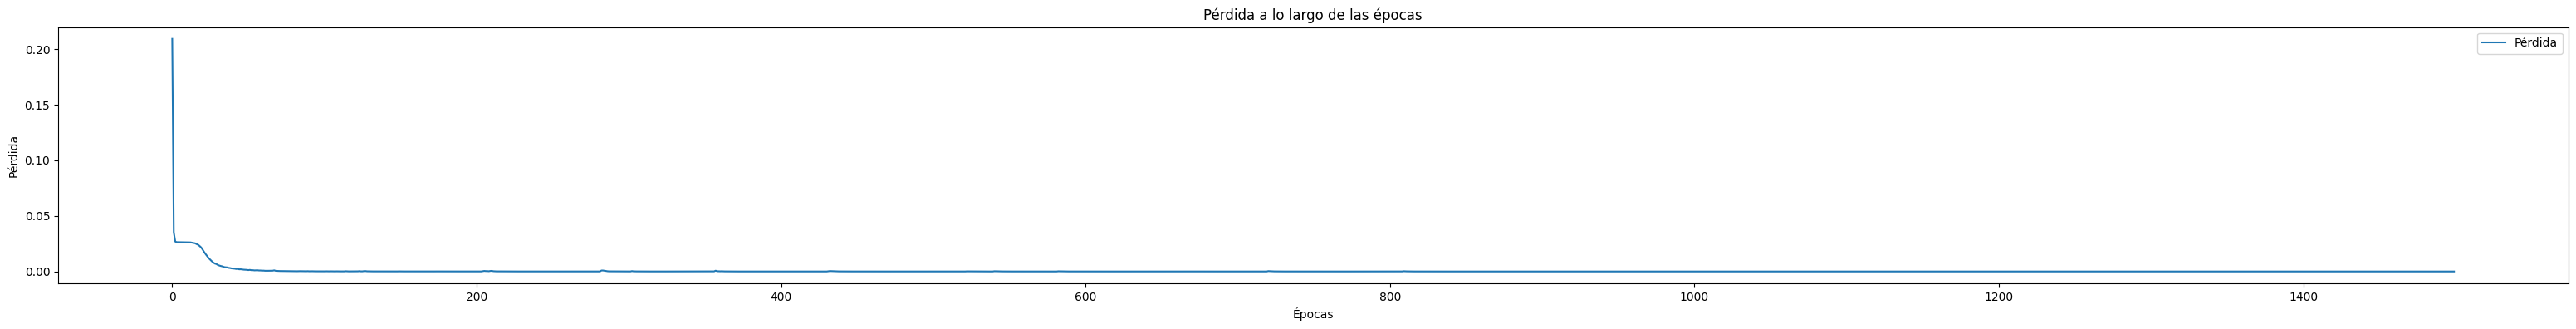

In [ ]:
figlength = np.max([10,  int(np.round(   np.sqrt(len(historia.history['loss']))  ) ) ])
plt.figure(figsize=(figlength,4))
plt.plot(historia.history['loss'])
plt.title('Pérdida a lo largo de las épocas'), plt.xlabel('Épocas'), plt.ylabel('Pérdida'), plt.legend(['Pérdida'], loc='upper right')
plt.show()

In [ ]:
guardar_modelo(ruta_modelo,modelo,nombre = 'SR+CNN',version='1500 épocas')

SR+CNN 1500 épocas ha sido importado desde el disco.

## Cargar modelo

In [ ]:
modelo = cargar_modelo(ruta_modelo,nombre = 'SR+CNN',version='1500 épocas')

SR+CNN 1500 épocas ha sido importado desde el disco.

In [ ]:
modelo_old = cargar_modelo(ruta_modelo,nombre = 'SR+CNN')

SR+CNN ha sido importado desde el disco.

## Crear data de prueba

In [ ]:
# Si se quieren importar varios meses
#meses = [(12,2022)]
#df = import_months(ruta_data,meses)
# Si solo se quiere importar una semana (o última fecha)
año, mes, día = (2022, 12, 21)
df = cargar_semana(ruta_data,año,mes,día)
df

,dt,kwh_rec,kvarh_rec,kwhr_del,kvarh_del,id_med,id_tipo_contrato
0,2022-12-14 00:00:00,0.000000,0.0,0.0,0.0,10,6
1,2022-12-14 00:15:00,0.000000,0.0,0.0,0.0,10,6
2,2022-12-14 00:30:00,0.000000,0.0,0.0,0.0,10,6
3,2022-12-14 00:45:00,0.000000,0.0,0.0,0.0,10,6
4,2022-12-14 01:00:00,0.000000,0.0,0.0,0.0,10,6
...,...,...,...,...,...,...,...
855547,2022-12-21 22:45:00,0.041871,0.0,0.0,0.0,2556,8
855548,2022-12-21 23:00:00,0.040966,0.0,0.0,0.0,2556,8
855549,2022-12-21 23:15:00,0.038728,0.0,0.0,0.0,2556,8
855550,2022-12-21 23:30:00,0.037093,0.0,0.0,0.0,2556,8


In [ ]:
### subdividir saltos
columns = df.columns

jumps = df.groupby('id_med')['dt'].apply(find_jumps).rename('jumps')
data_by_med = df.groupby('id_med').apply(df_to_numpy).rename('data')
data_by_med = pd.concat((jumps,data_by_med),axis=1)

df = data_by_med.apply(split_data,axis=1)
df = np.vstack(df.apply(lambda x : np.vstack(x)))
df = pd.DataFrame(df,columns = columns)

print('Si lo siguiente, tiene otros valores apartes de [0.0], es porque ocurren saltos temporales:\n',np.unique(np.mod(df['id_med'],1)))
df.head()

Si lo siguiente, tiene otros valores apartes de [0.0], es porque ocurren saltos temporales:
 [0.0]


,dt,kwh_rec,kvarh_rec,kwhr_del,kvarh_del,id_med,id_tipo_contrato
0,2022-12-14 00:00:00,262.514099,0.0,0.0,118.841835,7.0,3
1,2022-12-14 00:15:00,245.477722,0.0,0.0,126.307594,7.0,3
2,2022-12-14 00:30:00,226.122192,0.0,0.0,132.298889,7.0,3
3,2022-12-14 00:45:00,224.057373,0.0,0.0,137.678589,7.0,3
4,2022-12-14 01:00:00,226.643646,0.0,0.0,137.121384,7.0,3


In [ ]:
out = print_temp('Creando subseries...')
DF = pd.DataFrame(columns=['id_med','variable','inic-fin','data'])
for variable in variables:
  print_temp(f'Creando subseries para {variable}',out)
  result = df.groupby('id_med')[['dt',variable]].apply(triturador).reset_index()
  if result.shape[0] > 0:
    DF = pd.concat((DF,result),axis=0,ignore_index=True)
  else:
    print(f'No se presentan anomalías en la variable {variable}')
print_temp('',out)
DF.drop(columns=['idx'],inplace=True)
DF

,id_med,variable,inic-fin,data
0,106.0,kwh_rec,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[1004.9952393, 976.2769165, 953.2761841, 926.0..."
1,111.0,kwh_rec,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[1722.9334717, 1657.4805908, 1579.6071777, 152..."
2,119.0,kwh_rec,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[2938.5725098, 2838.276123, 2755.1010742, 2694..."
3,121.0,kwh_rec,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[2956.1481934, 2855.1259766, 2771.3520508, 271..."
4,126.0,kwh_rec,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[2126.1018066, 2051.0654297, 1979.3306885, 191..."
...,...,...,...,...
128,1562.0,kvarh_del,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[293.07813, 298.6062, 299.8143, 306.41824, 307..."
129,1574.0,kvarh_del,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
130,1598.0,kvarh_del,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[203.7225952, 203.9999542, 202.1660156, 199.83..."
131,1673.0,kvarh_del,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[129.68576, 127.18851, 71.37405, 60.28484, 107..."


In [ ]:
data = np.vstack(DF['data'].to_numpy())
CNN_input = SR(extend_series(data))

ts = data[:,(data.shape[1]-96*7):data.shape[1]]
CNN_input = CNN_input[:,(data.shape[1]-96*7):data.shape[1]]
probs = modelo.predict(CNN_input)
preds = np.where(probs < p, 0, 1)
idx_anom = np.where(np.any(preds,axis=1))[0]

DF_ = DF.loc[idx_anom,:].reset_index(drop=True)
data_ = data[idx_anom]
ts_ = ts[idx_anom]
preds_ = preds[idx_anom]
print(f'N° series con anomalías: {len(ts_)}')

5/5 [==============================] - 0s 4ms/step
N° series con anomalías: 88


In [ ]:
np.save(ruta_data + 'DF_test.npy', DF_)

## Cargar data de prueba

In [ ]:
DF = pd.DataFrame(np.load(ruta_data + 'DF_test.npy',allow_pickle=True),columns=['id_med','variable','inic-fin','data'])
DF

,id_med,variable,inic-fin,data
0,106.0,kwh_rec,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[1004.9952393, 976.2769165, 953.2761841, 926.0..."
1,111.0,kwh_rec,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[1722.9334717, 1657.4805908, 1579.6071777, 152..."
2,119.0,kwh_rec,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[2938.5725098, 2838.276123, 2755.1010742, 2694..."
3,121.0,kwh_rec,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[2956.1481934, 2855.1259766, 2771.3520508, 271..."
4,126.0,kwh_rec,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[2126.1018066, 2051.0654297, 1979.3306885, 191..."
...,...,...,...,...
83,1562.0,kvarh_del,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[293.07813, 298.6062, 299.8143, 306.41824, 307..."
84,1574.0,kvarh_del,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
85,1598.0,kvarh_del,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[203.7225952, 203.9999542, 202.1660156, 199.83..."
86,1673.0,kvarh_del,"[2022-12-14T00:00:00.000000000, 2022-12-21T23:...","[129.68576, 127.18851, 71.37405, 60.28484, 107..."


In [ ]:
data = np.vstack(DF['data'].to_numpy())
CNN_input = SR(extend_series(data))

ts = data[:,(data.shape[1]-96*7):data.shape[1]]
CNN_input = CNN_input[:,(data.shape[1]-96*7):data.shape[1]]
probs = modelo.predict(CNN_input)
preds = np.where(probs < p, 0, 1)

DF_ = DF.copy()
data_ = data.copy()
ts_ = ts.copy()
preds_ = preds.copy()

3/3 [==============================] - 0s 4ms/step


## Visualización

In [ ]:
markers = ['^','v','x','*','.']
for i in [0,1,7,8,10,11,12,20,21,26,27,28,29,36,42,44,54,55,58,61,66,70,71,72,73,74,75,80,82,84,85,86,87]:#[0,3,10,20,24,25,33,42,45,49,65]:
  id_med, variable, inic_fin = DF_.loc[i,['id_med','variable','inic-fin']]
  serie = ts_[i]
  anom = np.where(preds_[i] > 0)[0]
  #anom, etiquetas = ajustar_anomalias(serie,anom)
  anom, etiquetas = ajustar_anomalias_con_eliminaciones(serie,anom)
  timestamps = pd.date_range(start=inic_fin[0]+pd.Timedelta(days=1), end=inic_fin[1], freq='15T')

  plt.figure(figsize=(14,4))
  plt.plot(timestamps,serie,label='serie')

  for j, etiqueta in enumerate(['subidón','caída','pto. cambio','s/n','falsa anom.']):
    w = np.where(etiquetas == etiqueta)[0]
    if len(w) > 0:
      plt.scatter(timestamps[anom[w]],serie[anom[w]],label=etiqueta,marker=markers[j],color='red',s=80)

  plt.xlim(timestamps[0],timestamps[-1]+pd.Timedelta(days=1))
  plt.title(f'serie {i}, id_med {id_med}, {variable}')
  plt.legend(loc='lower right')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
_, preds_SR = calcular_input_output(data_)

probs2 = modelo_old.predict(CNN_input)
preds2 = np.where(probs2 < p, 0, 1)
preds_2 = preds.copy()

for i in [0,1,7,8,10,11,12,20,21,26,27,28,29,36,42,44,54,55,58,61,66,70,71,72,73,74,75,80,82,84,85,86,87]:
  id_med, variable, inic_fin = DF_.loc[i,['id_med','variable','inic-fin']]
  serie = ts_[i]
  anom = np.where(preds_[i] > 0)[0]
  timestamps = pd.date_range(start=inic_fin[0]+pd.Timedelta(days=1), end=inic_fin[1], freq='15T')

  plt.figure(figsize=(14,4))
  plt.plot(timestamps,serie,label='serie')
  plt.scatter(timestamps[anom],serie[anom],label='SR+CNN',marker='x',color='red',s=80)

  anom = np.where(preds_SR[i] > 0)[0]
  plt.scatter(timestamps[anom],serie[anom],label='SR',marker='o',color='None',edgecolors='orange',s=150)

  anom = np.where(preds_2[i] > 0)[0]
  plt.scatter(timestamps[anom],serie[anom],label='SR+CNN (old)',marker='s',color='None',edgecolors='green',s=200)

  plt.xlim(timestamps[0],timestamps[-1]+pd.Timedelta(days=1))
  plt.title(f'serie {i}, id_med {id_med}, {variable}')
  plt.legend(loc='lower right')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Aplicación

In [ ]:
modelo = cargar_modelo(ruta_modelo,nombre = 'SR+CNN')
hola=1+1


SR+CNN ha sido importado desde el disco.

In [ ]:
# Si se quieren importar varios meses
#meses = [(7,2022)]
#df = import_months(ruta_data,meses)
# Si solo se quiere importar una semana (o última fecha)
año, mes, día = (2022, 7, 22)
df = cargar_semana(ruta_data,año,mes,día)
df

,dt,kwh_rec,kvarh_rec,kwhr_del,kvarh_del,id_med,id_tipo_contrato
0,2022-07-15 00:00:00,0.0,0.0,0.0,0.0,10,6
1,2022-07-15 00:15:00,0.0,0.0,0.0,0.0,10,6
2,2022-07-15 00:30:00,0.0,0.0,0.0,0.0,10,6
3,2022-07-15 00:45:00,0.0,0.0,0.0,0.0,10,6
4,2022-07-15 01:00:00,0.0,0.0,0.0,0.0,10,6
...,...,...,...,...,...,...,...
846331,2022-07-22 22:45:00,0.0,0.0,0.0,0.0,2444,8
846332,2022-07-22 23:00:00,0.0,0.0,0.0,0.0,2444,8
846333,2022-07-22 23:15:00,0.0,0.0,0.0,0.0,2444,8
846334,2022-07-22 23:30:00,0.0,0.0,0.0,0.0,2444,8


In [ ]:
### subdividir saltos
columns = df.columns

jumps = df.groupby('id_med')['dt'].apply(find_jumps).rename('jumps')
data_by_med = df.groupby('id_med').apply(df_to_numpy).rename('data')
data_by_med = pd.concat((jumps,data_by_med),axis=1)

df = data_by_med.apply(split_data,axis=1)
df = np.vstack(df.apply(lambda x : np.vstack(x)))
df = pd.DataFrame(df,columns = columns)

print('Si lo siguiente, tiene otros valores apartes de [0.0], es porque ocurren saltos temporales:\n',np.unique(np.mod(df['id_med'],1)))
df.head()

Si lo siguiente, tiene otros valores apartes de [0.0], es porque ocurren saltos temporales:
 [0.0]


,dt,kwh_rec,kvarh_rec,kwhr_del,kvarh_del,id_med,id_tipo_contrato
0,2022-07-15 00:00:00,187.48357,0.0,0.0,191.16704,7.0,3
1,2022-07-15 00:15:00,185.37131,0.0,0.0,197.38878,7.0,3
2,2022-07-15 00:30:00,178.27896,0.0,0.0,200.65195,7.0,3
3,2022-07-15 00:45:00,169.81853,0.0,0.0,200.38141,7.0,3
4,2022-07-15 01:00:00,162.93874,0.0,0.0,199.68932,7.0,3


In [ ]:
out = print_temp('Creando subseries...')
DF = pd.DataFrame(columns=['id_med','variable','inic-fin','data'])
for variable in variables:
  print_temp(f'Creando subseries para {variable}',out)
  result = df.groupby('id_med')[['dt',variable]].apply(triturador).reset_index()
  if result.shape[0] > 0:
    DF = pd.concat((DF,result),axis=0,ignore_index=True)
  else:
    print(f'No se presentan anomalías en la variable {variable}')
print_temp('',out)
DF

,id_med,variable,inic-fin,data,level_1
0,106.0,kwh_rec,"[2022-07-15T00:00:00.000000000, 2022-07-22T23:...","[1820.62561, 1813.01245, 1815.18518, 1694.9738...",0.0
1,111.0,kwh_rec,"[2022-07-15T00:00:00.000000000, 2022-07-22T23:...","[1860.0528564, 1772.1580811, 1688.055542, 1594...",0.0
2,119.0,kwh_rec,"[2022-07-15T00:00:00.000000000, 2022-07-22T23:...","[3348.3569336, 3298.4543457, 3221.7414551, 308...",0.0
3,121.0,kwh_rec,"[2022-07-15T00:00:00.000000000, 2022-07-22T23:...","[3367.0915527, 3316.7668457, 3239.4169922, 310...",0.0
4,126.0,kwh_rec,"[2022-07-15T00:00:00.000000000, 2022-07-22T23:...","[2234.7566, 2135.2017, 2082.5264, 1997.3544, 1...",0.0
...,...,...,...,...,...
129,1668.0,kvarh_del,"[2022-07-15T00:00:00.000000000, 2022-07-22T23:...","[150.0664978, 127.0246429, 138.3420105, 154.25...",0.0
130,1673.0,kvarh_del,"[2022-07-15T00:00:00.000000000, 2022-07-22T23:...","[144.60429, 142.02551, 148.34814, 148.05058, 1...",0.0
131,1677.0,kvarh_del,"[2022-07-15T00:00:00.000000000, 2022-07-22T23:...","[154.66879, 156.75937, 158.51608, 160.55972, 1...",0.0
132,2048.0,kvarh_del,"[2022-07-15T00:00:00.000000000, 2022-07-22T23:...","[285.6407, 290.2867, 291.2119, 297.6131, 295.2...",0.0


In [ ]:
data = np.vstack(DF['data'].to_numpy())
CNN_input = SR(extend_series(data))

ts = data[:,(data.shape[1]-96*7):data.shape[1]]
CNN_input = CNN_input[:,(data.shape[1]-96*7):data.shape[1]]
probs = modelo.predict(CNN_input)
preds = np.where(probs < p, 0, 1)
idx_anom = np.where(np.any(preds,axis=1))[0]

DF_ = DF.loc[idx_anom,:].reset_index(drop=True)
data_ = data[idx_anom]
ts_ = ts[idx_anom]
preds_ = preds[idx_anom]
print(f'N° series con anomalías: {len(ts_)}')

5/5 [==============================] - 1s 160ms/step
N° series con anomalías: 71


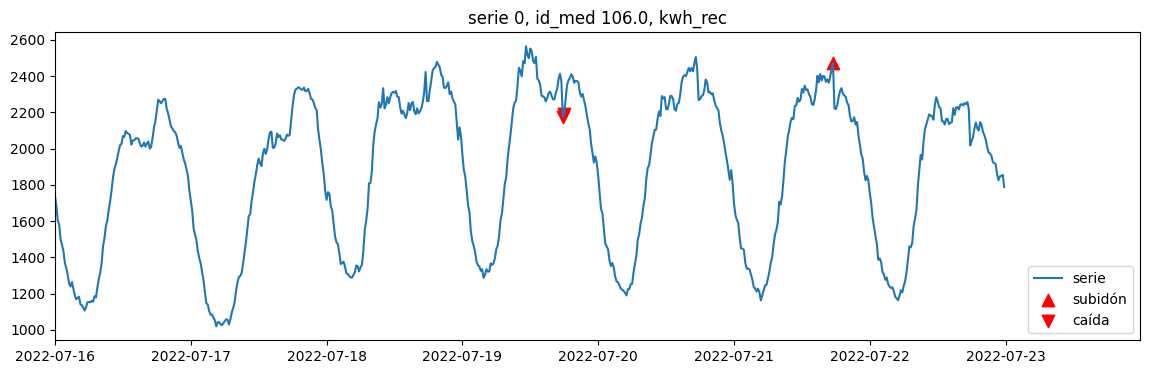

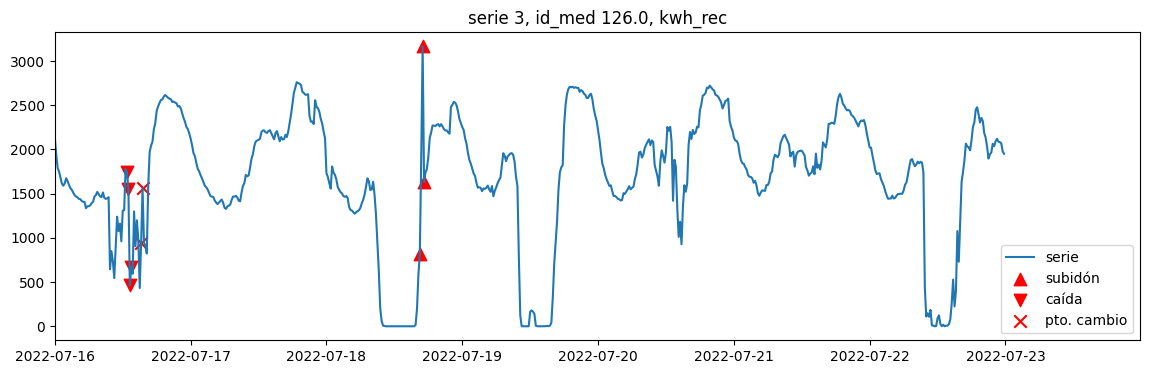

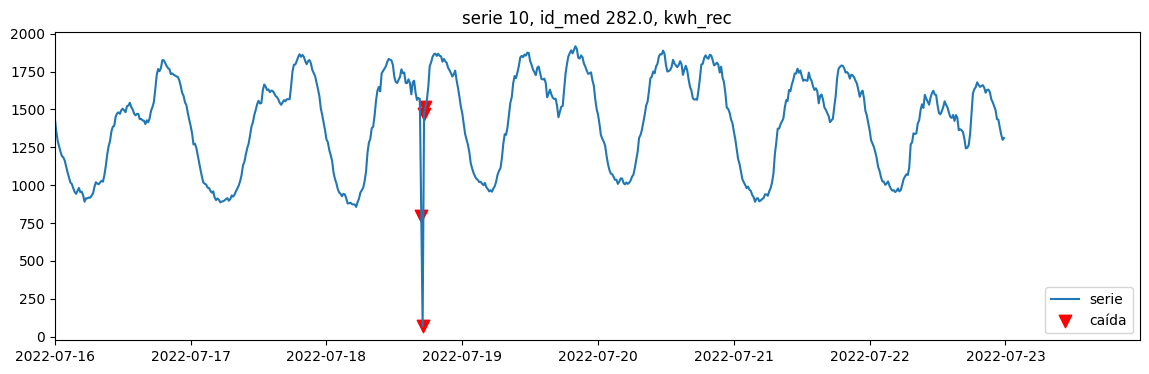

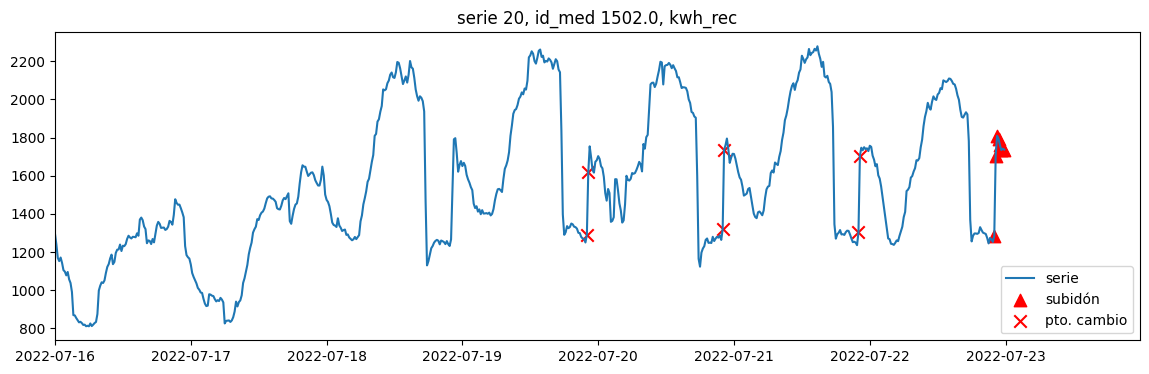

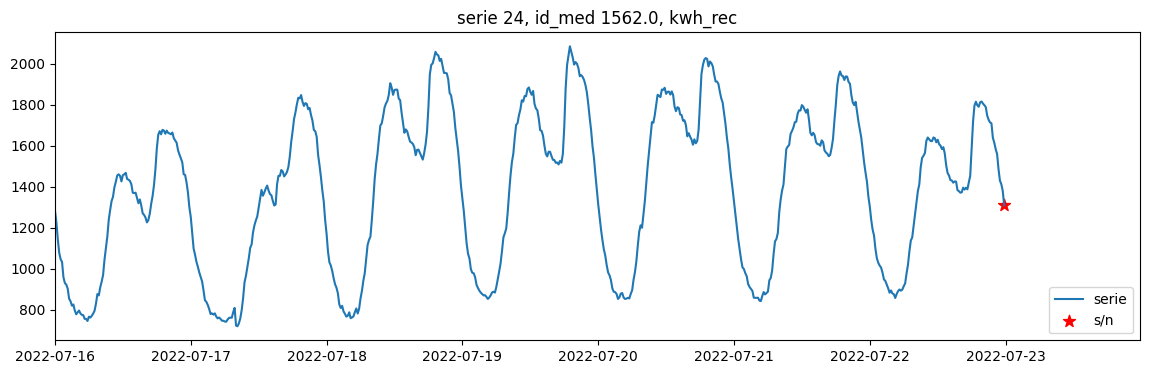

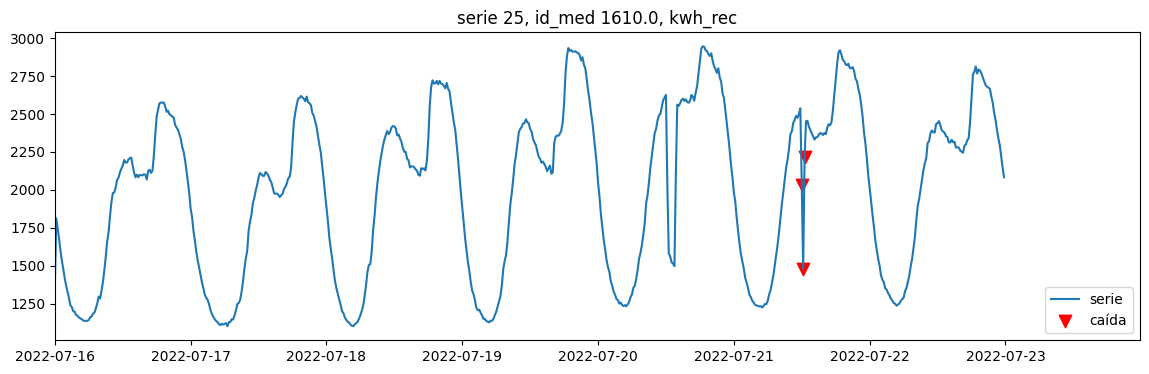

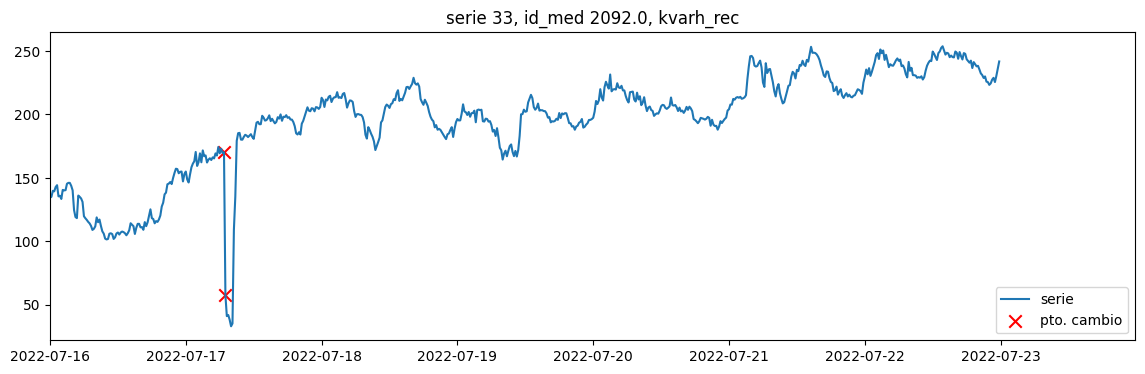

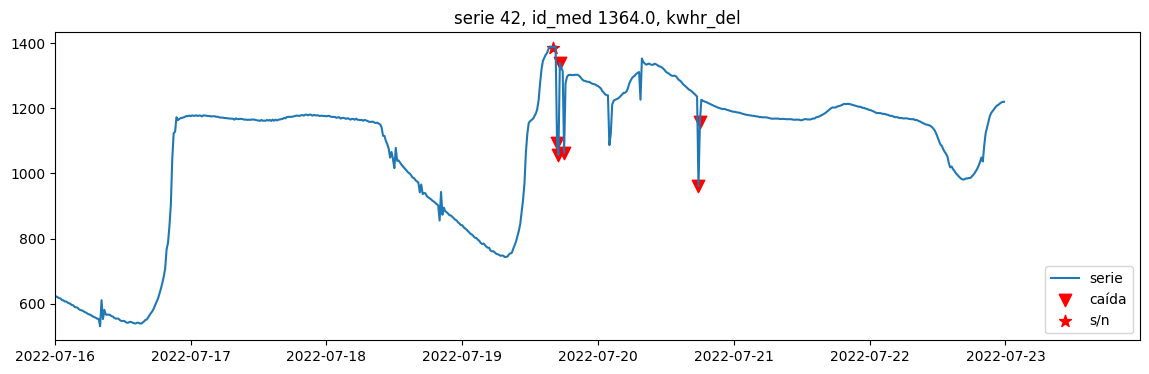

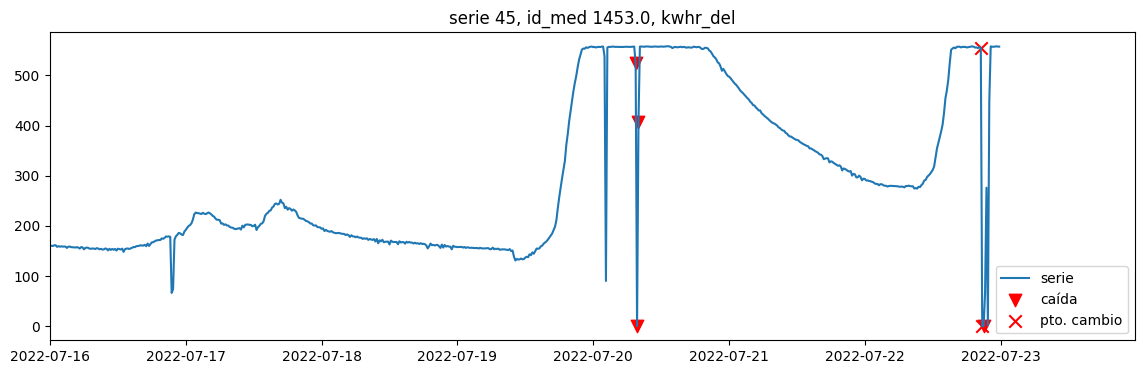

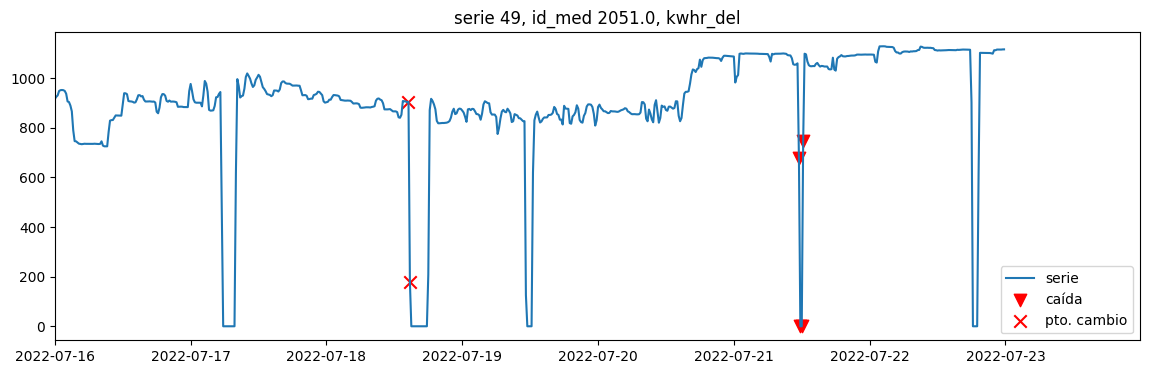

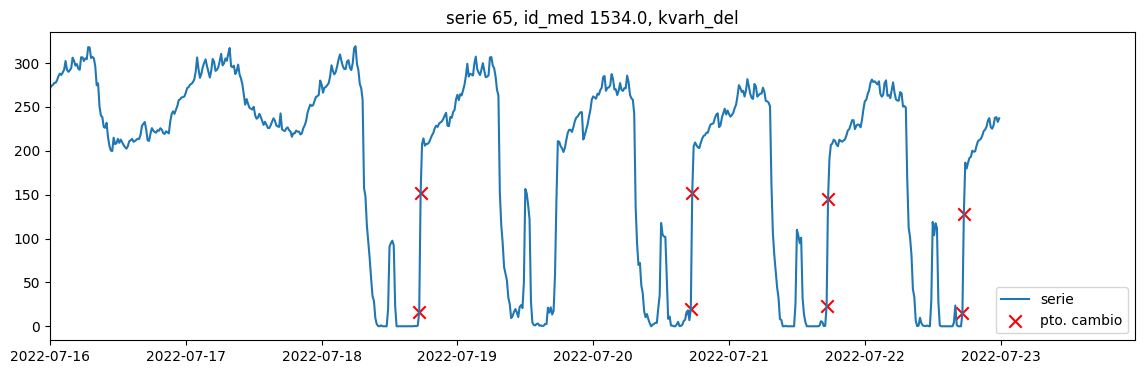

In [ ]:
markers = ['^','v','x','*','.']
for i in [0,3,10,20,24,25,33,42,45,49,65]:
  id_med, variable, inic_fin = DF_.loc[i,['id_med','variable','inic-fin']]
  serie = ts_[i]
  anom = np.where(preds_[i] > 0)[0]
  #anom, etiquetas = ajustar_anomalias(serie,anom)
  anom, etiquetas = ajustar_anomalias_con_eliminaciones(serie,anom)
  timestamps = pd.date_range(start=inic_fin[0]+pd.Timedelta(days=1), end=inic_fin[1], freq='15T')

  plt.figure(figsize=(14,4))
  plt.plot(timestamps,serie,label='serie')

  for j, etiqueta in enumerate(['subidón','caída','pto. cambio','s/n','falsa anom.']):
    w = np.where(etiquetas == etiqueta)[0]
    if len(w) > 0:
      plt.scatter(timestamps[anom[w]],serie[anom[w]],label=etiqueta,marker=markers[j],color='red',s=80)

  plt.xlim(timestamps[0],timestamps[-1]+pd.Timedelta(days=1))
  plt.title(f'serie {i}, id_med {id_med}, {variable}')
  plt.legend(loc='lower right')
  plt.show()